In [3]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# import data
hnf_data = pd.read_csv("../data/2010-2024 Humanitarian Needs and Funding - Raw Data.csv")

In [5]:
# To view first 5 rows of the data

hnf_data.head()


,Year,Plan,Crisis Country,Country Code,Metric,Value,Standardised Plan,Appeal Type,PiN Value for Dataviz,OUSG Metric
0,2010,Afghanistan,Afghanistan,AFG,People targeted,"7,800,000",Afghanistan,Consolidated Appeal Process (CAP),NaN,People in need
1,2010,Afghanistan,Afghanistan,AFG,Funding received,"223,824,925",Afghanistan,Consolidated Appeal Process (CAP),NaN,Funding received
2,2010,Afghanistan,Afghanistan,AFG,Funding requirements,"448,551,322",Afghanistan,Consolidated Appeal Process (CAP),NaN,Funding requirements
3,2010,Afghanistan,Afghanistan,AFG,People targeted,"5,400,000",Afghanistan,Consolidated Appeal Process (CAP),NaN,People in need
4,2010,Afghanistan,Afghanistan,AFG,Funding received,"345,246,607",Afghanistan,Consolidated Appeal Process (CAP),NaN,NaN


In [6]:
# Which Year had the most amount of People in need
need_by_year = hnf_data[hnf_data['Metric'] == 'People in need']
print(need_by_year['Year'])


9       2010
12      2010
15      2010
18      2010
21      2010
        ... 
1218    2024
1219    2024
1220    2024
1221    2024
1222    2024
Name: Year, Length: 402, dtype: int64


In [7]:
# Year with the highest people in need
max_need_row = need_by_year.loc[need_by_year['Value'].idxmax()]
year_with_max_need = max_need_row['Year']
print(f"The year with the most amount of people in need is: {year_with_max_need}")

The year with the most amount of people in need is: 2023


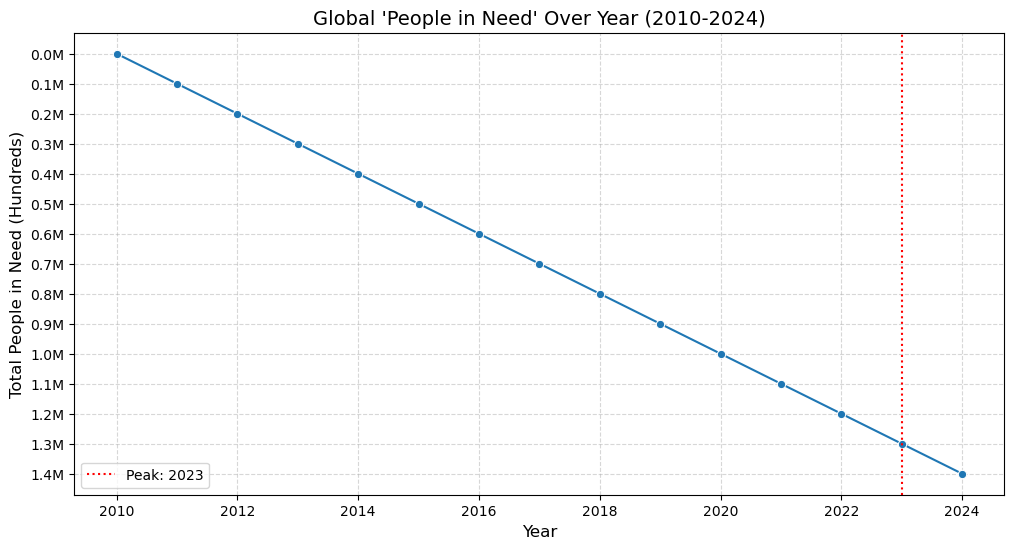

In [9]:
# To group by Year and sum 'Value' 
yearly_need = need_by_year.groupby('Year')['Value'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_need, x='Year', y='Value', marker='o')
plt.title("Global 'People in Need' Over Year (2010-2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total People in Need (Hundreds)", fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e1:.1f}M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.axvline(x=year_with_max_need, color='red', linestyle=':', label=f'Peak: {year_with_max_need}')
plt.legend()
plt.show()

In [10]:
# How have global humanitarian needs (People Targeted, People in need) evolved from 2010 to 2024?


# To filter the data for the two metrics of interest
metrics = ['People in need', 'People targeted']
filter_data = hnf_data[hnf_data['Metric'].isin(metrics)]

In [14]:
#To group by Year and Metric, then sum the values globally
global_trends = filter_data.groupby(['Year', 'Metric'])['Value'].sum().reset_index()

In [11]:
#data span
filter_data = filter_data.dropna(subset=['Value'])
print(f"📊 Data spans from {filter_data['Year'].min()} to {filter_data['Year'].max()}")


📊 Data spans from 2010 to 2024


In [17]:
#  Key Statistics (2010-2024)
metrics = ['People in need', 'People targeted']
filter_data = hnf_data[hnf_data['Metric'].isin(metrics)].copy()

filter_data['Value'] = pd.to_numeric(
    filter_data['Value'].astype(str).str.replace(',', ''), 
    errors='coerce'
)

trend_pivot = filter_data.groupby(['Year', 'Metric'])['Value'].sum().unstack()

# To calculate the statistics
stats = filter_data.groupby('Metric')['Value'].agg(['sum', 'mean', 'min', 'max', 'std'])

print("📈 Key Statistics (2010-2024):")
print(stats.map(lambda x: f"{x:,.0f}" if pd.notna(x) else "N/A").T)

# To calculate coverage ratio 
if 'People targeted' in trend_pivot.columns and 'People in need' in trend_pivot.columns:
    coverage_ratio = trend_pivot['People targeted'].sum() / trend_pivot['People in need'].sum()
    print(f"\n🔍 Global Coverage Ratio: {coverage_ratio:.1%} of needs were targeted")
else:
    print("\n⚠️ Could not calculate coverage ratio - missing required metrics")

📈 Key Statistics (2010-2024):
Metric People in need People targeted
sum     2,542,788,850     189,769,831
mean        6,325,345       3,514,256
min                 0         120,000
max        40,100,000      14,700,000
std         6,562,847       2,828,658

🔍 Global Coverage Ratio: 7.5% of needs were targeted


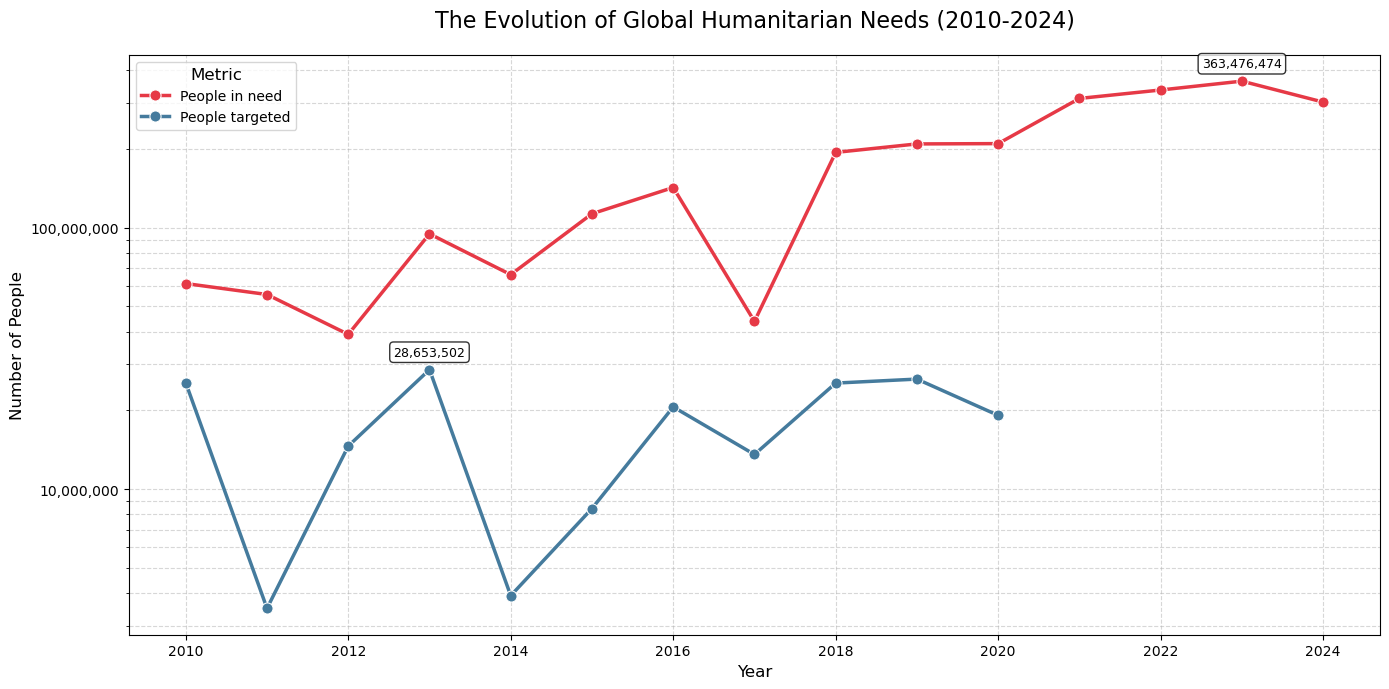

In [ ]:
# The Evolution of Global Humanitarian Needs (2010-2024) plot
plt.figure(figsize=(14, 7))
palette = {'People in need': '#e63946', 'People targeted': '#457b9d'}

# Line plot
ax = sns.lineplot(
    data=global_trends,
    x='Year',
    y='Value',
    hue='Metric',
    palette=palette,
    linewidth=2.5,
    marker='o',
    markersize=8
)

plt.title('The Evolution of Global Humanitarian Needs (2010-2024)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.yscale('log') if trend_pivot.max().max() > 1e8 else None  # Auto-log scale for large ranges
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))

for metric in ['People in need', 'People targeted']:
    max_val = trend_pivot[metric].max()
    year = trend_pivot[trend_pivot[metric] == max_val].index[0]
    ax.annotate(f'{max_val:,.0f}', xy=(year, max_val), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title='Metric', title_fontsize=12)
plt.tight_layout()
plt.show()

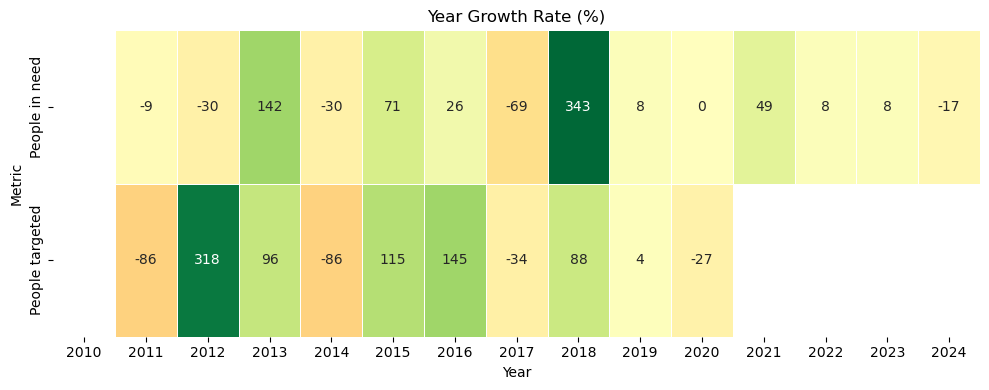

In [23]:
# To calculate the Year growth rates
year_growth = trend_pivot.pct_change(fill_method=None) * 100

# To create heatmap
plt.figure(figsize=(10,4))
sns.heatmap(year_growth.T, annot=True, fmt=".0f", cmap="RdYlGn", center=0,
            cbar=False, linewidths=.5)
plt.title('Year Growth Rate (%)')
plt.tight_layout()
plt.show()